<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Using-dask-and-zarr-for-multithreaded-input/output" data-toc-modified-id="Using-dask-and-zarr-for-multithreaded-input/output-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Using dask and zarr for multithreaded input/output</a></span><ul class="toc-item"><li><span><a href="#zarr" data-toc-modified-id="zarr-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>zarr</a></span></li><li><span><a href="#dask" data-toc-modified-id="dask-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>dask</a></span><ul class="toc-item"><li><span><a href="#Example,-write-and-read-zarr-arrays-using-multiple-threads" data-toc-modified-id="Example,-write-and-read-zarr-arrays-using-multiple-threads-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Example, write and read zarr arrays using multiple threads</a></span></li><li><span><a href="#Create-230-Mbytes-of--fake-data" data-toc-modified-id="Create-230-Mbytes-of--fake-data-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Create 230 Mbytes of  fake data</a></span></li><li><span><a href="#Copy-to-a-zarr-file-on-disk,-using-multiple-threads" data-toc-modified-id="Copy-to-a-zarr-file-on-disk,-using-multiple-threads-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Copy to a zarr file on disk, using multiple threads</a></span></li><li><span><a href="#Add-some-attributes" data-toc-modified-id="Add-some-attributes-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Add some attributes</a></span></li><li><span><a href="#Create-an-array-of-zeros----note-that-compression-shrinks-it-from-230-Mbytes-to-321-bytes" data-toc-modified-id="Create-an-array-of-zeros----note-that-compression-shrinks-it-from-230-Mbytes-to-321-bytes-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Create an array of zeros -- note that compression shrinks it from 230 Mbytes to 321 bytes</a></span></li><li><span><a href="#copy-input-to-output-using-chunks" data-toc-modified-id="copy-input-to-output-using-chunks-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>copy input to output using chunks</a></span></li><li><span><a href="#Create-a-dask-array-from-a-zarr-disk-file" data-toc-modified-id="Create-a-dask-array-from-a-zarr-disk-file-1.2.7"><span class="toc-item-num">1.2.7&nbsp;&nbsp;</span>Create a dask array from a zarr disk file</a></span></li><li><span><a href="#The-following-calculation-uses-numpy,-so-it-releases-the-GIL" data-toc-modified-id="The-following-calculation-uses-numpy,-so-it-releases-the-GIL-1.2.8"><span class="toc-item-num">1.2.8&nbsp;&nbsp;</span>The following calculation uses numpy, so it releases the GIL</a></span></li><li><span><a href="#Note-that-result-hasn't-been-computed-yet" data-toc-modified-id="Note-that-result-hasn't-been-computed-yet-1.2.9"><span class="toc-item-num">1.2.9&nbsp;&nbsp;</span>Note that result hasn't been computed yet</a></span></li><li><span><a href="#Now-do-the-calculation" data-toc-modified-id="Now-do-the-calculation-1.2.10"><span class="toc-item-num">1.2.10&nbsp;&nbsp;</span>Now do the calculation</a></span></li><li><span><a href="#You-can-evaluate-your-own-functions-on-dask-arrays" data-toc-modified-id="You-can-evaluate-your-own-functions-on-dask-arrays-1.2.11"><span class="toc-item-num">1.2.11&nbsp;&nbsp;</span>You can evaluate your own functions on dask arrays</a></span></li></ul></li></ul></li></ul></div>

    conda install zarr
    conda install dask
    conda install pytz  #for our timestamp timezone

In [1]:
import numpy as np
import zarr
import time
import datetime
import pytz
from zarr.util import human_readable_size
import dask
import dask.array as da
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler
from dask.diagnostics.profile_visualize import visualize

# Using dask and zarr for multithreaded input/output

* Many python programmers use [hdf5](https://support.hdfgroup.org/HDF5/) through either the [h5py](http://www.h5py.org/) or [pytables](http://www.pytables.org/) modules to store large dense arrays.  One drawback of the hdf5 implementation is that it is basically **single-threaded**, that is only one core can read or write to a dataset at any one time.  Multithreading makes data compression much more attractive, because data sections can be decompressing/compressing simultaneouly while the data is read/written.

## zarr

* [zarr](http://zarr.readthedocs.io/en/latest/?badge=latest) keeps the h5py interface (which is similar to numpy's), but allows different choices for file compression and is fully multithreaded.  See [Alistair Miles original blog entry](http://alimanfoo.github.io/2016/05/16/cpu-blues.html) for a discussion of the motivation behind zarr.

## dask

* [dask](http://dask.pydata.org/en/latest/) is a Python library that implements lazy data structures (array, dataframe, bag) and a clever thread/process scheduler.  It integrates with zarr to allow calculations on datasets that don't fit into core memory, either in a single node or across a cluster.

### Example, write and read zarr arrays using multiple threads

### Create 230 Mbytes of  fake data

In [2]:
wvel_data = np.random.normal(2000, 1000, size=[8000,7500]).astype(np.float32)
human_readable_size(wvel_data.nbytes)

'228.9M'

### Copy to a zarr file on disk, using multiple threads

In [3]:
item='disk1_data'
store = zarr.DirectoryStore(item)
group=zarr.hierarchy.group(store=store,overwrite=True,synchronizer=zarr.ThreadSynchronizer())
the_var='wvel'
out_zarr1=group.zeros(the_var,shape=wvel_data.shape,dtype=wvel_data.dtype,chunks=[2000,7500])
out_zarr1[...]=wvel_data[...]

### Add some attributes

In [4]:
now=datetime.datetime.now(pytz.UTC)
timestamp= int(now.strftime('%s'))
out_zarr1.attrs['history']='written for practice'
out_zarr1.attrs['creation_date']=str(now)
out_zarr1.attrs['gmt_timestap']=timestamp
out_zarr1

<zarr.core.Array '/wvel' (8000, 7500) float32>

### Create an array of zeros -- note that compression shrinks it from 230 Mbytes to 321 bytes

In [5]:
a2 = np.zeros([8000,7500],dtype=np.float32)
item='disk2_data'
store = zarr.DirectoryStore(item)
group=zarr.hierarchy.group(store=store,overwrite=True,synchronizer=zarr.ThreadSynchronizer())
the_var='wvel'
out_zarr2=group.zeros(the_var,shape=a2.shape,dtype=a2.dtype,chunks=[2000,7500])
out_zarr2

<zarr.core.Array '/wvel' (8000, 7500) float32>

### copy input to output using chunks

In [6]:
item='disk2_data'
store = zarr.DirectoryStore(item)
group=zarr.hierarchy.group(store=store,overwrite=True,synchronizer=zarr.ThreadSynchronizer())
the_var='wvel'
out_zarr=group.empty(the_var,shape=wvel_data.shape,dtype=wvel_data.dtype,chunks=[2000,7500])
out_zarr2[...]=out_zarr1[...]
out_zarr2

<zarr.core.Array '/wvel' (8000, 7500) float32>

### Create a dask array from a zarr disk file

In [7]:
da_input = da.from_array(out_zarr2, chunks=out_zarr1.chunks)
da_input

dask.array<array, shape=(8000, 7500), dtype=float32, chunksize=(2000, 7500)>

### The following calculation uses numpy, so it releases the GIL

In [8]:
result=(da_input**2. + da_input**3.).mean(axis=0)
result

dask.array<mean_agg-aggregate, shape=(7500,), dtype=float32, chunksize=(7500,)>

### Note that result hasn't been computed yet

Here is a graph of how the calculation will be split among 4 threads

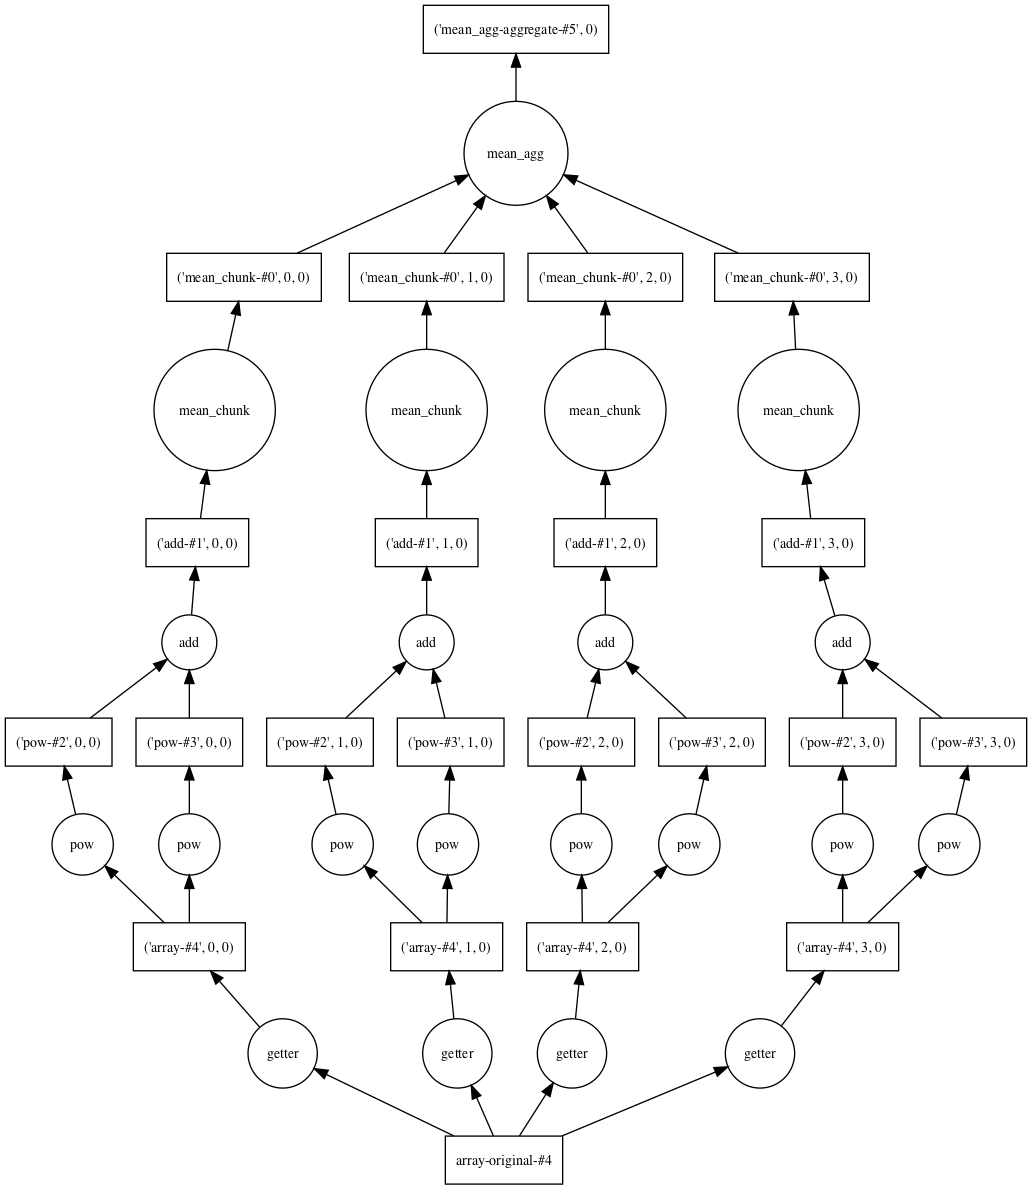

In [9]:
from dask.dot import dot_graph
dot_graph(result.dask)

### Now do the calculation

In [10]:
with Profiler() as prof, ResourceProfiler(dt=0.1) as rprof,\
              CacheProfiler() as cprof:
    answer = result.compute()

Visualize the cpu, memory and cache for the 4 threads

In [11]:
visualize([prof, rprof,cprof], min_border_top=15, min_border_bottom=15)

Column(id='6bd4abb0-7339-4a14-ab7e-c26988a95256', ...)

### You can evaluate your own functions on dask arrays

If your functons release the GIL, you can get multithreaded computation using [dask.delayed](http://dask.pydata.org/en/latest/delayed.html)